Задача: построить прогноз для банковских вкладов value_rub для группы банка = 1 и секторов с 1 по 4 на следующие два года.

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.special import boxcox, inv_boxcox
from scipy import stats
from itertools import product
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from dateutil.relativedelta import relativedelta

data = pd.read_csv('allBank_balance_101_sector.csv', index_col = [0], parse_dates=[0], dayfirst = True)
data = data.query(' (1 <= sector_id <= 4) and (bank_group_id == 1)')
data = data.drop(['sector_id', 'bank_group_id', 'value_usd'], axis=1).sort_index()
data = data.resample("1M").mean()

def check_adfuller(data, column):
    test = sm.tsa.adfuller(data.iloc[:,column])
    print('adf', test[0])
    print('pvalue', test[1])
    print('Critical_values', test[4])
    if test[0] > test[4]['5%']:
        print('Нестационарный ряд, есть единичные корни')
    else:
        print('Стационарный ряд, единичных корней нет')

data

,value_rub
report_date,
2007-02-28,20.645039
2007-03-31,26.463473
2007-04-30,32.672688
2007-05-31,37.633860
2007-06-30,40.992252
...,...
2019-01-31,471.656349
2019-02-28,572.542179
2019-03-31,577.363992


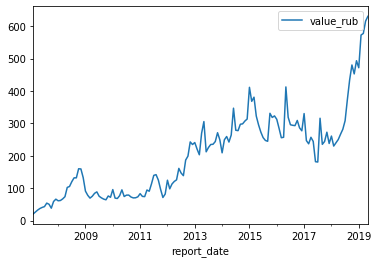

In [2]:
data.plot()

Проверка на стационарность и декомпозиция ряда:

adf 0.7519089931362508
pvalue 0.9908188611202015
Critical_values {'1%': -3.476273058920005, '5%': -2.881687616548444, '10%': -2.5775132580261593}
Нестационарный ряд, есть единичные корни


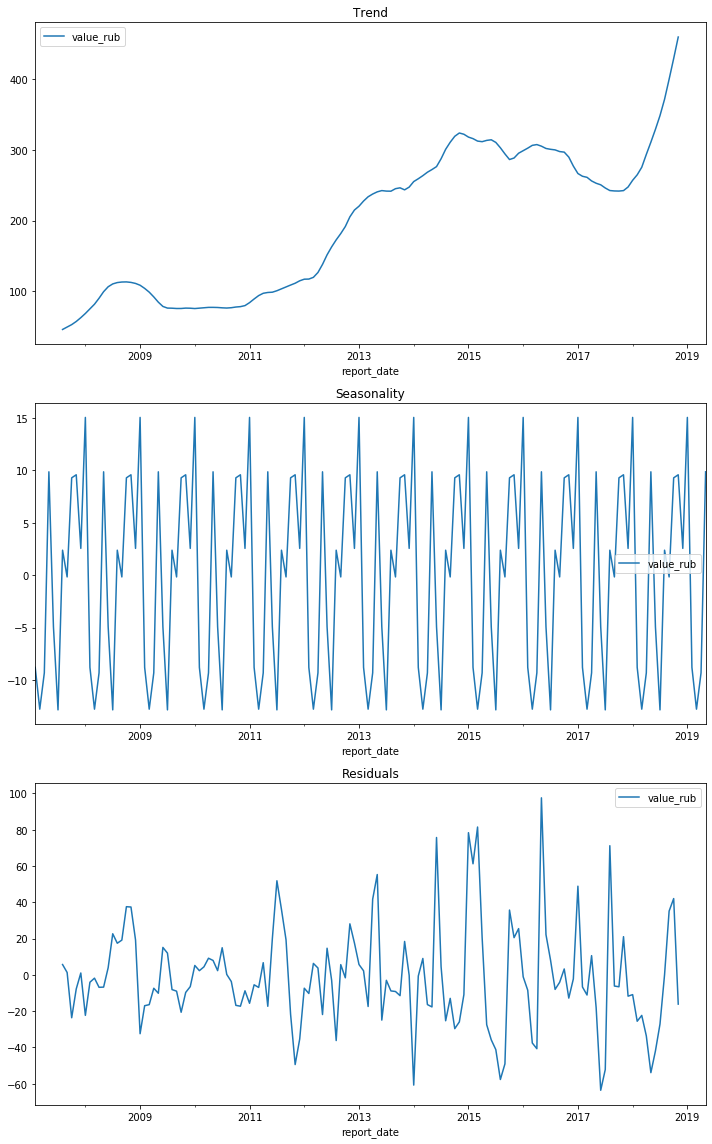

In [3]:
decomposed = seasonal_decompose(data, freq = 12)
plt.figure(figsize = (10, 16))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

check_adfuller(data, 0)

Применение критерия Бокса-Кокса для стационарности:

In [4]:
data['boxcox'], lmbda = stats.boxcox(data)
check_adfuller(data, 1)

adf -0.848222936680543
pvalue 0.8045451139581601
Critical_values {'1%': -3.476273058920005, '5%': -2.881687616548444, '10%': -2.5775132580261593}
Нестационарный ряд, есть единичные корни


Ряд нестационарен, попробуем использовать сезонное дифференцирование и снова проверим на стационарность:

adf -2.2213388224379713
pvalue 0.19859204645846257
Critical_values {'1%': -3.4846672514209773, '5%': -2.8853397507076006, '10%': -2.5794629869786503}
Нестационарный ряд, есть единичные корни


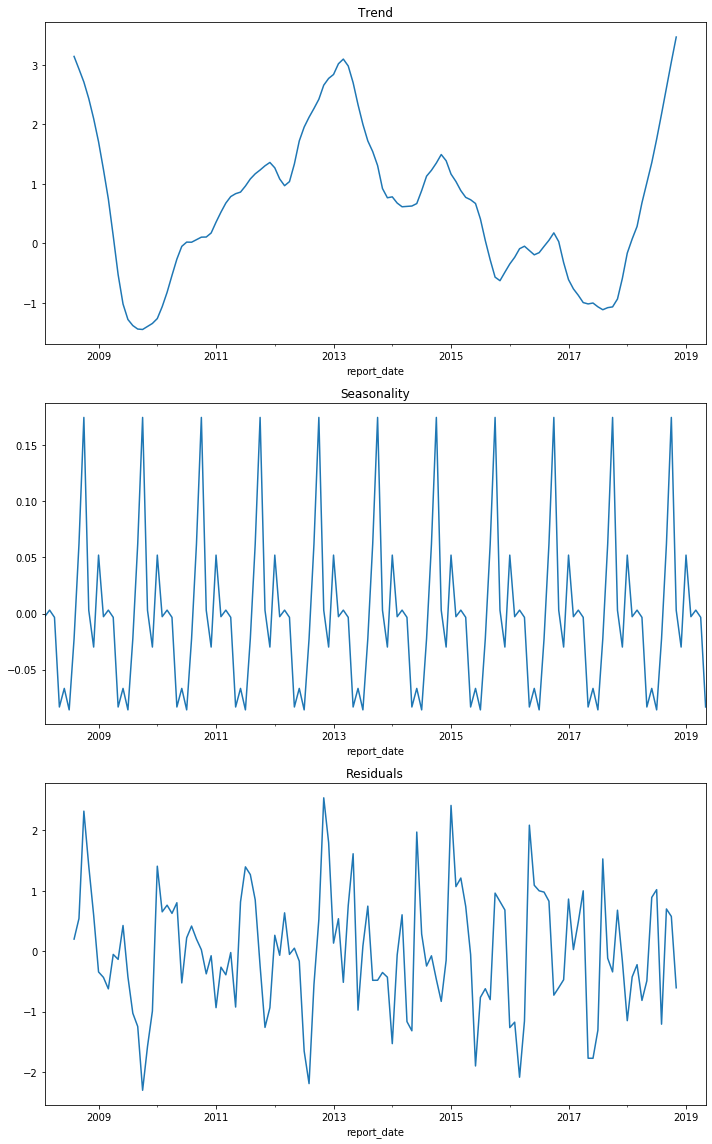

In [5]:
data['diff'] = data['boxcox'] - data['boxcox'].shift(12)

decomposed = seasonal_decompose(data['diff'][12:])
plt.figure(figsize = (10, 16))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

check_adfuller(data.dropna(),2)

Ряд все еще нестационарен, присутствует тренд. Применим дополнительно обычное дифференцирование:

adf -5.272115525159455
pvalue 6.252898873320071e-06
Critical_values {'1%': -3.485585145896754, '5%': -2.885738566292665, '10%': -2.5796759080663887}
Стационарный ряд, единичных корней нет


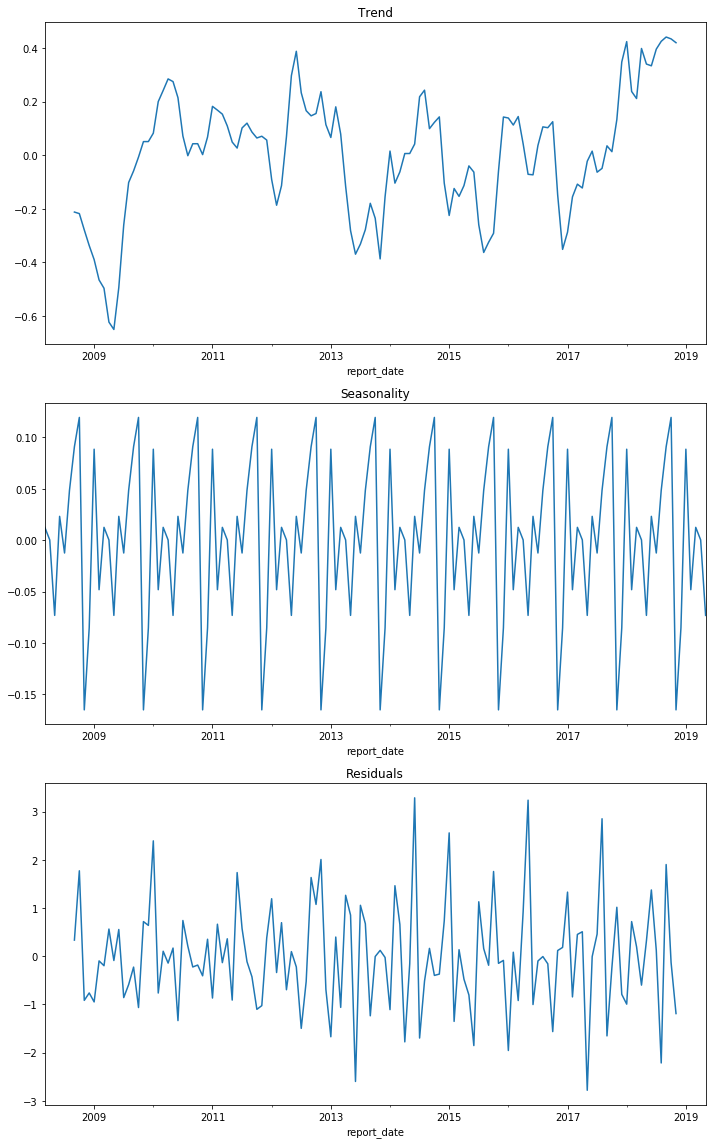

In [6]:
data['diff2'] = data['diff'] - data['diff'].shift(1)

decomposed = seasonal_decompose(data['diff2'][13:])
plt.figure(figsize = (10, 16))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

check_adfuller(data.dropna(),3)

Ряд теперь выглядет более стационарным, гипотеза о нестационарности отвергается.

Далее посмотрим на ACF  PACF, подберем по ним начальное приближение для гиперпараметров модели.

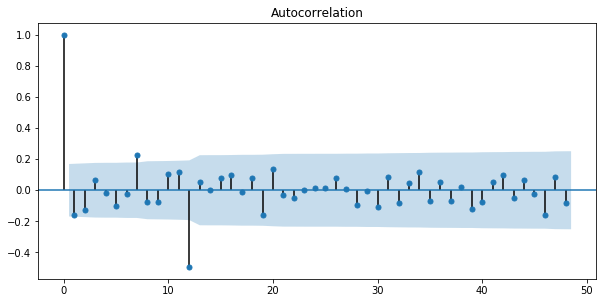

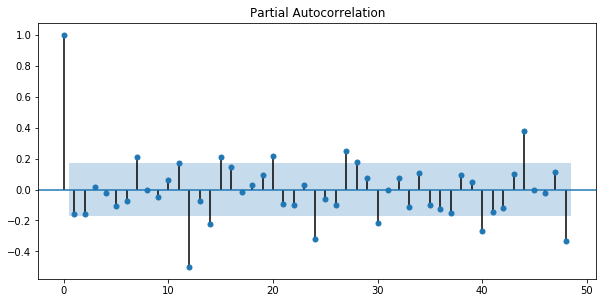

In [7]:
plt.figure(figsize = (10, 16))
plt.subplot(311)
sm.graphics.tsa.plot_acf(data['diff2'].dropna().values.squeeze(), lags = 48, ax=plt.gca())
plt.show()

plt.figure(figsize = (10, 16))
plt.subplot(312)
sm.graphics.tsa.plot_pacf(data['diff2'].dropna().values.squeeze(), lags = 48, ax=plt.gca())
plt.show()

In [8]:
#зададим начальное приближение для гипермараметров

p = range(0,2)
q = range(0,2)

P = range(0,4)
Q = range(0,2)

d = 1
D = 1

params = product(p, q, P, Q)
params_list = list(params)
len(params_list)

32

Переберем все сочетания гиперпараметров и выберем модель с наилучшим значением информационного критерия Акаике:

In [9]:
%%time

results = []
best_aic = float("inf")


for param in params_list:
    try:
        model = sm.tsa.statespace.SARIMAX(data['boxcox'], order=(
        param[0], d, param[1]), seasonal_order = (param[2], D, param[3], 12)).fit(disp = -1)
    except:
        print ('wrong params:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_params = param
    results.append([param, model.aic])

Wall time: 47.7 s


In [10]:
results = pd.DataFrame(results)
results.columns = ['params', 'aic']
results.sort_values('aic', ascending = True).head()

,params,aic
9,"(0, 1, 0, 1)",331.448308
17,"(1, 0, 0, 1)",332.270948
11,"(0, 1, 1, 1)",332.408991
25,"(1, 1, 0, 1)",332.560826
1,"(0, 0, 0, 1)",332.672546


Лучшая модель:

In [11]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             boxcox   No. Observations:                  148
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -162.724
Date:                            Sun, 26 Jul 2020   AIC                            331.448
Time:                                    20:41:57   BIC                            340.164
Sample:                                02-28-2007   HQIC                           334.990
                                     - 05-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1748      0.087     -1.998      0.046      -0.346      -0.003
ma.S.L12      -0.9976      7.311     -0.136      0.891     -15.326      13.331
sigma2         0.5232      3.804      0.138      0.891      -6.933       7.979
===================================================================================
Ljung-Box (Q):                       33.94   Jarque-Bera (JB):                18.00
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             0.64
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Рассмотирм остатки лучшей модели:

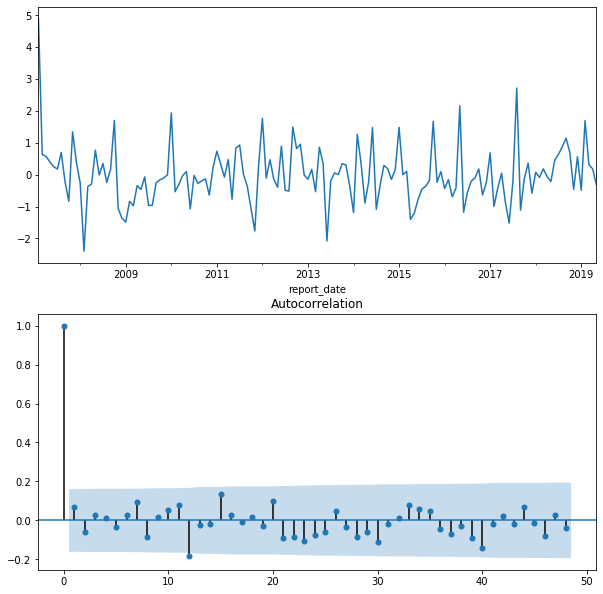

In [12]:
plt.figure(figsize = (10, 16))
plt.subplot(311)
best_model.resid.dropna().plot()

plt.subplot(312)
sm.graphics.tsa.plot_acf(best_model.resid.dropna().values.squeeze(), lags = 48, ax=plt.gca())
plt.show()

In [13]:
print('Критерий Дики-Фуллера: р = %f' % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])
print('Критерий Стьюдента: р = %f' % stats.ttest_1samp(best_model.resid[13:],0)[1])

Критерий Дики-Фуллера: р = 0.000000
Критерий Стьюдента: р = 0.568607


Остатки несмещены (по критерию Стьюдента), визуально и по критерию Дики-Фуллера стационарны, нет автокорреляции. Ниже посмотрим на описание данных моделью:

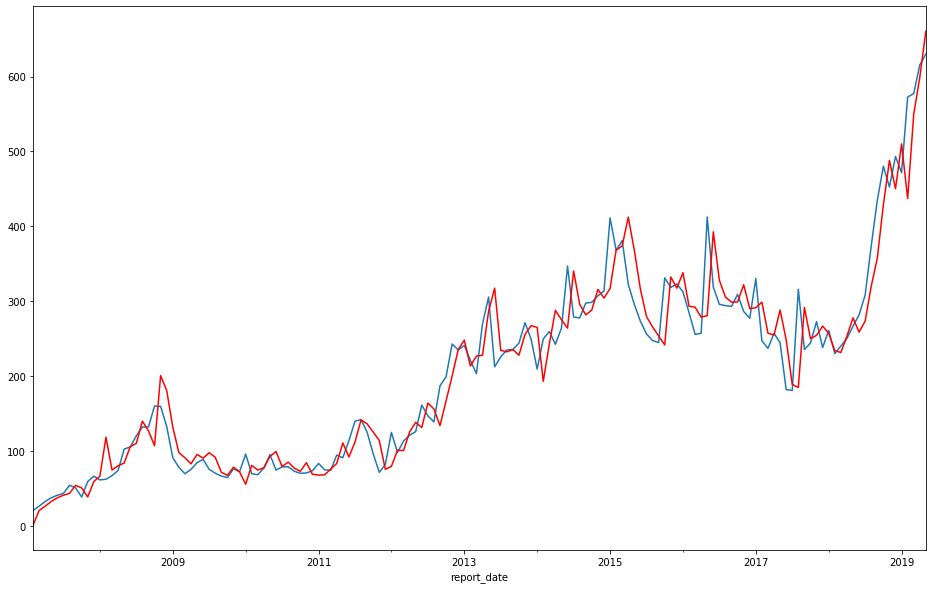

In [14]:
data['model'] = inv_boxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize = (16, 10))
data['value_rub'].plot()
data['model'].dropna().plot(color = 'r')
plt.show()

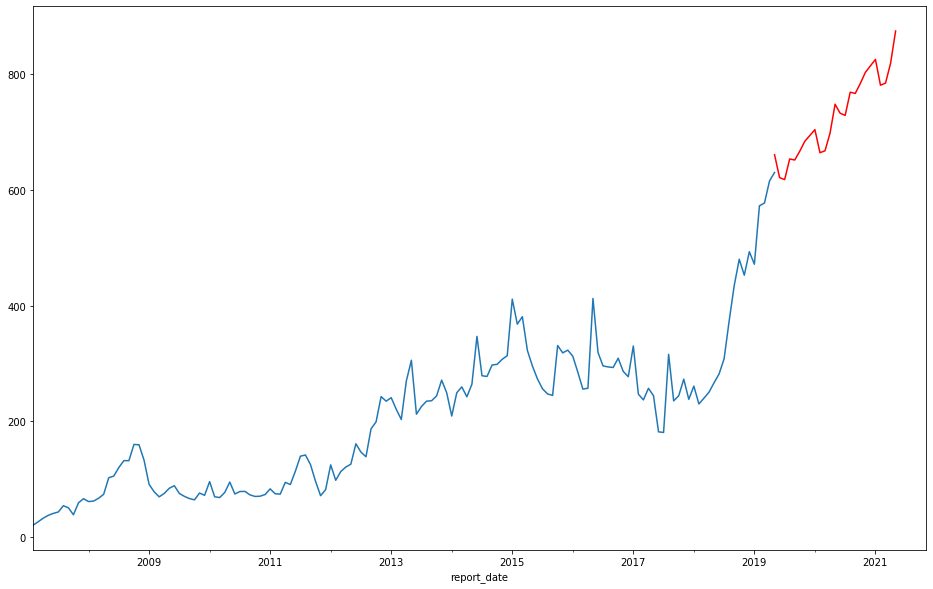

In [17]:
#строим прогноз
new_data = data[['value_rub']]
dates = [datetime.strptime('2019-05-31', '%Y-%m-%d') + \
         relativedelta(month = m, year = 2019+y) for m in range(0,12) for y in range(0,3)]
future = pd.DataFrame(index = dates, columns = new_data.columns)
future = future.sort_index()
new_data = pd.concat([new_data, future])
new_data['forecast'] = inv_boxcox(best_model.predict(start = 147, end = 171), lmbda)

plt.figure(figsize = (16, 10))
data['value_rub'].plot()
new_data['forecast'].plot(color = 'r')
plt.show()

Можно заметить, что на прогнозе тренд выглядит достаточно линейно в отличие от структуры тренда на изначальных данных, но в целом модель хорошо справилась и учла сезонность ряда.